In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Run cell to increase font sizes. Usefull when saving plots
SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (12,9)

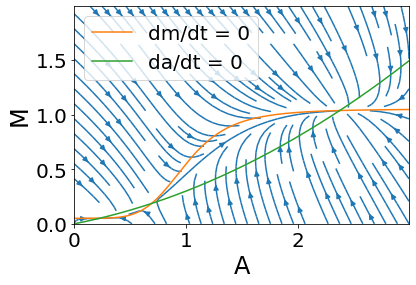

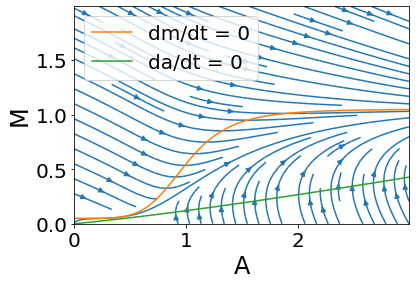

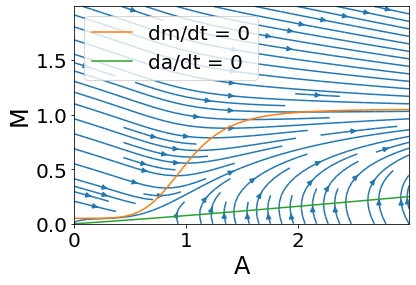

In [11]:
def dMdt(M, A, L, Vmax=1, n=5, Km=2, k1=0.05, k2=1, k3=1, k4=1, k5=0.2):
    return k1 + k2 * (1 - (1/(1 + A**n))) - k3 * M

def dAdt(M, A, L, Vmax=1, n=5, Km=2, k1=0.05, k2=1, k3=1, k4=1, k5=0.2):
    return k4 * M * L - k5 * A - Vmax* M * A / (Km + A)

def M_nullcline(M, A, L, Vmax=1, n=5, Km=2, k1=0.05, k2=1, k3=1, k4=1, k5=0.2):

    return (k1 + k2 * (1 - 1/(1 + A**n))) / k3

def A_nullcline(M, A, L, Vmax=1, n=5, Km=2, k1=0.05, k2=1, k3=1, k4=1, k5=0.2):

    return k5 * A / (k4 * L - (Vmax * A) / (Km + A))

def plot_lac_operon_streamplot(Ms, As, L, Vmax=1, n=5, Km=2, k1=0.05, k2=1, k3=1, k4=1, k5=0.2):
    
    # Compute the change of M and A for all values in the lists Ms and As
    x_velocities, y_velocities = [], []
    for M in Ms:

        x_temp, y_temp = [], []
        
        for A in As:
            x_temp.append(dAdt(M, A, L))
            y_temp.append(dMdt(M, A, L))

        x_velocities.append(x_temp)
        y_velocities.append(y_temp)

    # Compute nullclines for dm/dt=0 and da/dt=0
    m_nulls = M_nullcline(Ms, As, L)
    a_nulls = A_nullcline(Ms, As, L)

    x_velocities = np.array(x_velocities)
    y_velocities = np.array(y_velocities)

    plt.ylim(Ms[0], Ms[-1])
    plt.streamplot(As, Ms, x_velocities, y_velocities, density=1)

    plt.plot(As, m_nulls, label="dm/dt = 0")
    plt.plot(As, a_nulls, label="da/dt = 0")

    plt.xlabel("A")
    plt.ylabel("M")

    plt.legend()
    plt.show()

%matplotlib inline

As = np.arange(0, 3, 0.01)
Ms = np.arange(0, 2, 0.01)
plot_lac_operon_streamplot(Ms, As, L=1)
plot_lac_operon_streamplot(Ms, As, L=2)
plot_lac_operon_streamplot(Ms, As, L=3)

